# MIRI PSF Photometry #2 - F770W PSF Photometry

**Author**: Ori Fox
<br>
**Last Updated**: March, 2022

## Table of contents
1. [Introduction](#intro)<br>
2. [Setup](#setup)<br>
    2.1 [Python imports](#py_imports)<br>
    2.2 [Plotting functions imports](#matpl_imports)<br>
    2.3 [PSF FWHM dictionary](#psf_fwhm)<br>
3. [Import image to analyze](#data)<br>
    3.1 [Display image](#display_data)<br>
    3.2 [Convert image units and apply pixel area map](#convert_data)<br>
4. [Analyze F770W Image](#analyze_image)<br>
    4.1 [Create a synthetic PSF with WebbPSF (single or grid)](#create_webbpsf)<br>
    4.2 [Perform PSF photometry](#psf_photometry)<br>

1.<font color='white'>-</font>Introduction <a class="anchor" id="intro"></a>
------------------

**Data**: MIRI simulated images obtained using [MIRISIM](https://www.stsci.edu/jwst/science-planning/proposal-planning-toolbox/mirisim) and run through the [JWST pipeline](https://jwst-pipeline.readthedocs.io/en/latest/) of Isochrone of 10-Gyr old population, [Fe/H]=-1 Population placed at 2.5 kpc from the Sun. Salpeter-like IMF, tweaked to have more massive stars (since positions are random, it ensures at least a few bright stars in each image). Kept only sources brighter than J=17 (random cut to speed up MIRISim) and fainter than Ks=10 (to avoid too-bright stars that would have PSF spikes clearly cut by MIRISim in the image)

Here is the [ReadMe](https://stsci.app.box.com/s/2b6evrie2swaybarxhdmpqizktl3g0wm/file/869444882607). All data simulations can be found on [STScI's simulation page](https://www.stsci.edu/jwst/science-planning/proposal-planning-toolbox/simulated-data).
PSF Photometry can be obtained using:

* single PSF model obtained from WebbPSF
* grid of PSF models from WebbPSF
* single effective PSF (ePSF)
* grid of effective PSF (bonus part II)

The notebook shows:

* how to obtain the PSF model from WebbPSF (or build an ePSF)
* how to perform PSF photometry on the image
* how to cross-match the catalogs of the different images (bonus part I)

2.<font color='white'>-</font>Setup <a class="anchor" id="setup"></a>
------------------

In this section we import all the necessary python packages and we define some plotting parameters.

### 2.1<font color='white'>-</font>Python imports<a class="anchor" id="py_imports"></a> ###

In [1]:
import os

if not os.environ.get('WEBBPSF_PATH'):
    os.environ['WEBBPSF_PATH'] = '/data/webbpsf-data'

import sys
import time

import numpy as np

import pandas as pd

import glob as glob

import urllib.request

import tarfile

from astropy.io import fits
from astropy.visualization import simple_norm
from astropy.nddata import NDData
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.table import Table, QTable
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy import units as u

from photutils.background import MMMBackground, MADStdBackgroundRMS, Background2D
from photutils.detection import DAOStarFinder
from photutils import EPSFBuilder, GriddedPSFModel
from photutils.psf import DAOGroup, extract_stars, IterativelySubtractedPSFPhotometry

import jwst
from jwst.datamodels import ImageModel

import webbpsf
from webbpsf.utils import to_griddedpsfmodel

import pysynphot  # PYSIN_CDBS must be defined in the user's environment (see note below)

from collections import OrderedDict
from astropy.wcs import WCS

In [2]:
#
# General tools
#
import glob
import os
import shutil
import sys
import random
import urllib
import zipfile
#
# Astropy tools
#
from astropy.coordinates import match_coordinates_sky, SkyCoord
from astropy.io import fits, ascii
from astropy.stats import SigmaClip, sigma_clipped_stats
from astropy.table import Table, Column, vstack
import astropy.units as u
from astropy.visualization import LogStretch, LinearStretch, PercentileInterval, ManualInterval
from astropy.nddata import Cutout2D
#
# JWST models
#
from jwst import datamodels, associations
from jwst.datamodels import ImageModel, dqflags
#
# Matplotlib tools
#
from matplotlib import style, pyplot as plt, rcParams
from matplotlib.colors import LogNorm
from matplotlib.pyplot import figure
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
#
# Numpy library
#
import numpy as np
#
# Photutils library and tools
#
import photutils
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry
from photutils import Background2D, MedianBackground, ModeEstimatorBackground, MMMBackground
#
# Scipy tools
#
from scipy import stats
from scipy.interpolate import CubicSpline
#
# Use 90% of the window width
#
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

2022-04-14 05:34:57,623 - stpipe - WARNING - /var/folders/yh/kl4y3s1x3_j3ywy3qq67g3vc0001kc/T/ipykernel_46391/2969300567.py:51: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML



<div class="alert alert-block alert-info">

**Note on pysynphot**: Data files for pysynphot are distributed separately by Calibration Reference Data System. They are expected to follow a certain directory structure under the root directory, identified by the PYSYN_CDBS environment variable that must be set prior to using this package. In the example below, the root directory is arbitrarily named /my/local/dir/trds/. \
export PYSYN_CDBS=/my/local/dir/trds/ \
See documentation [here](https://pysynphot.readthedocs.io/en/latest/#installation-and-setup) for the configuration and download of the data files.
    
<div >

### 2.2<font color='white'>-</font>Plotting function imports<a class="anchor" id="matpl_imports"></a> ###

<div class="alert alert-block alert-warning">
    <h3><u><b>Warning</b></u></h3>

If the plots in this notebook don't render properly, you may need to install LaTeX. Find more information on a system-wide installation [here](https://www.latex-project.org/get/) and on a Jupyter-specific nbextension [here](https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/nbextensions/latex_envs/README.html).
</div>

In [3]:
%matplotlib inline
from matplotlib import style, pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as ticker

from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['axes.titlesize'] = plt.rcParams['axes.labelsize'] = 30
plt.rcParams['xtick.labelsize'] = plt.rcParams['ytick.labelsize'] = 20

font1 = {'family': 'helvetica', 'color': 'black', 'weight': 'normal', 'size': '12'}
font2 = {'family': 'helvetica', 'color': 'black', 'weight': 'normal', 'size': '20'}

In [4]:
%matplotlib inline
# Figure size
plt.rcParams['figure.figsize'] = [15, 15]
# Figure text and font
plt.rc('text', usetex=True)
plt.rc('font', size=15)

### 2.3<font color='white'>-</font>PSF FWHM dictionary<a class="anchor" id="psf_fwhm"></a> ###

The dictionary contains the NIRCam point spread function (PSF) FWHM, from the [NIRCam Point Spread Function](https://jwst-docs.stsci.edu/near-infrared-camera/nircam-predicted-performance/nircam-point-spread-functions) JDox page. The FWHM are calculated from the analysis of the expected NIRCam PSFs simulated with [WebbPSF](https://www.stsci.edu/jwst/science-planning/proposal-planning-toolbox/psf-simulation-tool). 

**Note**: this dictionary will be updated once the values for the FWHM will be available for each detectors after commissioning.

In [5]:
filters = ['F560W', 'F770W', 'F1000W', 'F1130W', 'F1280W', 'F1500W', 'F1800W', 'F2100W', 'F2550W']

psf_fwhm = [1.636, 2.187, 2.888, 3.318, 3.713, 4.354, 5.224, 5.989, 7.312] #pixls

dict_utils = {filters[i]: {'psf fwhm': psf_fwhm[i]} for i in range(len(filters))}

### 2.4 Useful Functions

In [6]:
def imshow_me_wcolorbar(img, vmin, vmax, tlabel, xlabel, ylabel, blabel, cmap):
    '''
    Function to show an image.
    
    Inputs
    ----------
    img : 2D numpy.ndarray
        The input 2D array.
    vmin : float
        The minimum value for the colorbar.
    vmax : float
        The maximum value for the colorbar.
    tlabel : string
        The plot title.
    xlabel : string
        The X-axis label.
    ylabel : string
        The Y-axis label.
    blabel : string
        The colorbar label.
    cmap : string
        The name of the colormap.
    '''
    
    fig, ax = plt.subplots()
    cax = ax.imshow(img, vmin=vmin, vmax=vmax, origin='lower', cmap=cmap)
    ax_divider = make_axes_locatable(ax)
    cax1 = ax_divider.append_axes('right', size='3%', pad='2%')
    cb = fig.colorbar(cax, cax=cax1)
    cb.ax.set_ylabel(r'{0}'.format(blabel))
    ax.set_xlabel(r'{0}'.format(xlabel))
    ax.set_ylabel(r'{0}'.format(ylabel))
    ax.set_title(r'{0}'.format(tlabel))
    plt.tight_layout()
    
    return

In [7]:
def imshow_me_wcolorbar_setup(img, vmin, vmax, tlabel, xlabel, ylabel, blabel, cmap):
    '''
    Function to setup an image to show. Similar to imshow_me_wcolorbar,
    but it does not show the image directly, thus allowing to plot
    something else after the call.
    
    Inputs
    ----------
    img : 2D numpy.ndarray
        The input 2D array.
    vmin : float
        The minimum value for the colorbar.
    vmax : float
        The maximum value for the colorbar.
    tlabel : string
        The plot title.
    xlabel : string
        The X-axis label.
    ylabel : string
        The Y-axis label.
    blabel : string
        The colorbar label.
    cmap : string
        The name of the colormap.
    '''
    
    cax = ax.imshow(img, vmin=vmin, vmax=vmax, origin='lower', cmap=cmap)
    ax_divider = make_axes_locatable(ax)
    cax1 = ax_divider.append_axes('right', size='3%', pad='2%')
    cb = fig.colorbar(cax, cax=cax1)
    cb.ax.set_ylabel(r'{0}'.format(blabel))
    ax.set_xlabel(r'{0}'.format(xlabel))
    ax.set_ylabel(r'{0}'.format(ylabel))
    ax.set_title(r'{0}'.format(tlabel))
    
    return

In [8]:
def imshow_cutouts(img, tab, id_sel, xlabel, ylabel, cmap):
    '''
    Function to show four cutouts from an image.
    
    Inputs
    ----------
    img : 2D numpy.ndarray
        The input 2D array.
    tab : Table
        The table with at least (x,y,id) columns.
    id_sel : array(int)
        The ID of the sources in tab to show in the cutouts.
    xlabel : string
        The X-axis label.
    ylabel : string
        The Y-axis label.
    cmap : string
        The name of the colormap.
    '''
    
    fig, ax = plt.subplots(2, 2)

    x, y = tab['x'][tab['id'] == id_sel[0]], tab['y'][tab['id'] == id_sel[0]]
    cutout = Cutout2D(img, (x, y), (51, 51))
    ax[0, 0].imshow(cutout.data, vmin=-0.1, vmax=1.0, origin='lower', cmap=cmap)
    ax[0, 0].scatter(cutout.input_position_cutout[0], cutout.input_position_cutout[1], lw=0.5, s=15, 
                     marker='o', edgecolors='deepskyblue', facecolors='none')
    ax[0, 0].annotate(r'(x,y)$\sim$({0},{1})'.format(int(x[0]), int(y[0])), xy=(0.5, 0.95), xycoords='axes fraction',
                      horizontalalignment='center', verticalalignment='center')
    ax[0, 0].set_xlabel(r'{0}'.format(xlabel))
    ax[0, 0].set_ylabel(r'{0}'.format(ylabel))

    x, y = tab['x'][tab['id'] == id_sel[1]], tab['y'][tab['id'] == id_sel[1]]
    cutout = Cutout2D(img, (x, y), (51, 51))
    ax[0, 1].imshow(cutout.data, vmin=-0.1, vmax=1.0, origin='lower', cmap=cmap)
    ax[0, 1].scatter(cutout.input_position_cutout[0], cutout.input_position_cutout[1], lw=0.5, s=15, 
                     marker='o', edgecolors='deepskyblue', facecolors='none')
    ax[0, 1].annotate(r'(x,y)$\sim$({0},{1})'.format(int(x[0]), int(y[0])), xy=(0.5, 0.95), xycoords='axes fraction', 
                      horizontalalignment='center', verticalalignment='center')
    ax[0, 1].set_xlabel(r'{0}'.format(xlabel))
    ax[0, 1].set_ylabel(r'{0}'.format(ylabel))

    x, y = tab['x'][tab['id'] == id_sel[2]], tab['y'][tab['id'] == id_sel[2]]
    cutout = Cutout2D(img, (x, y), (51, 51))
    ax[1, 0].imshow(cutout.data, vmin=-0.1, vmax=1.0, origin='lower', cmap=cmap)
    ax[1, 0].scatter(cutout.input_position_cutout[0], cutout.input_position_cutout[1], lw=0.5, s=15, 
                     marker='o', edgecolors='deepskyblue', facecolors='none')
    ax[1, 0].annotate(r'(x,y)$\sim$({0},{1})'.format(int(x[0]), int(y[0])), xy=(0.5, 0.95), xycoords='axes fraction', 
                      horizontalalignment='center', verticalalignment='center')
    ax[1, 0].set_xlabel(r'{0}'.format(xlabel))
    ax[1, 0].set_ylabel(r'{0}'.format(ylabel))

    x, y = tab['x'][tab['id'] == id_sel[3]], tab['y'][tab['id'] == id_sel[3]]
    cutout = Cutout2D(img, (x, y), (51, 51))
    ax[1, 1].imshow(cutout.data, vmin=-0.1, vmax=1.0, origin='lower', cmap=cmap)
    ax[1, 1].scatter(cutout.input_position_cutout[0], cutout.input_position_cutout[1], lw=0.5, s=15, 
                     marker='o', edgecolors='deepskyblue', facecolors='none')
    ax[1, 1].annotate(r'(x,y)$\sim$({0},{1})'.format(int(x[0]), int(y[0])), xy=(0.5, 0.95), xycoords='axes fraction', 
                      horizontalalignment='center', verticalalignment='center')
    ax[1, 1].set_xlabel(r'{0}'.format(xlabel))
    ax[1, 1].set_ylabel(r'{0}'.format(ylabel))
    
    plt.tight_layout()
    
    return

In [9]:
def arcsec2pix(x):
    '''
    Function that converts arcsec in MIRIM pixels.
    It is used to setup the secondary axes in a plot.
    
    Inputs
    ----------
    x : float or array(float)
        The value in arcsec.
        
    Outputs
    ----------
    The value(s) in MIRIM pixel.
    '''
    
    return x/0.11

In [10]:
def pix2arcsec(x):
    '''
    Function that converts MIRIM pixels in arcsec.
    It is used to setup the secondary axes in a plot.
    
    Inputs
    ----------
    x : float or array(float)
        The value in MIRIM pixels.
        
    Outputs
    ----------
    The value(s) in arcsec.
    '''
    
    return x*0.11

These last three functions will be used to speed-up the exercise.

In [11]:
def prepare_image(img_name):
    '''
    Function that reads one image, flag all pixels with DQ flags different 
    from [0, 2, 4, 6] and adds a random background gradient.
    To be used in the exercise.
    
    Inputs
    ----------
    img_name : string
        The name of the image.
        
    Outputs
    ----------
    img : ImageModel
        The data model of the image.
    img_mod : 2D numpy.ndarray
        The image data with the additional random background gradient.
    '''
    
    img = datamodels.open(img_name)
    ok = np.zeros(img.data.shape, dtype='int')
    for v in [0, 2, 4, 6]:
        ok = ok + np.where(img.dq == v, 1, 0)

    img.data[ok == 0] = np.nan
    
    x = np.linspace(0, 1, img.meta.subarray.xsize)
    y = np.linspace(0, 1, img.meta.subarray.ysize)
    X, Y = np.meshgrid(x, y)
    if (np.random.rand(1) > 0.5):
        sx = +1
    else:
        sx = -1
    if (np.random.rand(1) > 0.5):
        sy = +1
    else:
        sy = -1
    Z = (10*(np.random.rand(1)-0.5))*np.exp(sx*X/(4+2*(np.random.rand(1)-0.5)))*np.exp(sy*Y/(4+4*(np.random.rand(1)-0.5)))
    
    img_mod = img.data.copy() + Z
    
    _, sky_med, sky_sig = sigma_clipped_stats(img_mod[np.isfinite(img_mod)], sigma=5.0, maxiters=5)
    
    print('')
    print(r' Suggested min value: {0}'.format(sky_med-sky_sig))
    print(r' Suggested max value: {0}'.format(sky_med+sky_sig))
    print('')

    cmin = sky_med-sky_sig
    cmax = sky_med+sky_sig
    
    return img, img_mod, cmin, cmax

In [12]:
def prepare_table(img, xy_tmp, aperture_radius, sky, flux, rad_label):
    '''
    Function that performs additional steps discussed in the notebook.
    To be used in the exercise.
    
    Inputs
    ----------
    img : ImageModel
        The data model of the image.
    xy_tmp : Table
        The table created by DAOStarFinder with the sources detected
        in the image.
    aperture_radius : float
        The aperture radius used for the aperture photometry.
    sky : array(float)
        The array with the local sky background for each source.
    flux : array(float)
        The array with the sky-subtracted flux for each source.
    rad_label : string
        The label for the photometry in the Table.
        
    Outputs
    ----------
    aperture_table : Table
        The final astro-photometric table.
    '''
    
    aperture_table = Table()

    aperture_table['x'] = xy_tmp['xcentroid']
    aperture_table['y'] = xy_tmp['ycentroid']
    aperture_table['sharpness'] = xy_tmp['sharpness']
    aperture_table['roundness1'] = xy_tmp['roundness1']
    aperture_table['roundness2'] = xy_tmp['roundness2']

    aperture_table['id'] = xy_tmp['id']
    
    aperture_table['local_sky_' + rad_label] = sky
    aperture_table['aperture_' + rad_label + '_skysub'] = flux
    
    keep_good = np.logical_and(np.isfinite(aperture_table['aperture_' + rad_label + '_skysub']), 
                               aperture_table['aperture_' + rad_label + '_skysub'] > 0.)
    aperture_table = aperture_table[keep_good]
        
    aperture_table['mag_' + rad_label] = -2.5*np.log10(aperture_table['aperture_' + rad_label + '_skysub'])

    aperture_table['flag_' + rad_label] = np.zeros(len(aperture_table), dtype=int)
    for s in aperture_table:
        jmin = max(1, int(np.floor(s['y']-aperture_radius)))
        jmax = min(round(s['y']+aperture_radius)+1, img.shape[0])
        imin = max(1, int(np.floor(s['x']-aperture_radius)))
        imax = min(round(s['x']+aperture_radius)+1, img.shape[1])
        if (np.sum(img.dq[jmin:jmax, imin:imax] == 6) > 0):
            s['flag_' + rad_label] = 6
        elif (np.sum(img.dq[jmin:jmax, imin:imax] == 2) > 0):
            s['flag_' + rad_label] = 2
        elif (np.sum(img.dq[jmin:jmax, imin:imax] == 4) > 0):
            s['flag_' + rad_label] = 4       

    aperture_table['ra'] = aperture_table['x']
    aperture_table['dec'] = aperture_table['y']
    for a in aperture_table:
        rd = img.meta.wcs.transform("detector", "world", a['x'], a['y'])    
        a['ra'] = rd[0]
        if (a['ra'] > 180):
            a['ra'] -= 360.0
        a['dec'] = rd[1]
        
    return aperture_table

In [13]:
def prepare_phot_cal(cat_name, tmp, sel_radius):
    '''
    Function that cross-matches two catalogs and plot the positional residuals.
    To be used in the exercise.
    
    Inputs
    ----------
    cat_name : string
        The name of the pipeline source catalog
    tmp : Table
        The astro-photometric table.
    sel_radius : float
        The radius for the positional-residual selection in arcsec.
        
    Outputs
    ----------
    calib_cat : Table
        The pipeline source catalog.
    ind_i2d_cat: array(int)
        The array with the indexes from match_sky_coordinates.
    dist_2d: array(float)
        The array with the 2D distances from match_sky_coordinates.
    '''
    
    calib_cat = Table.read(cat_name)

    coord_cal = SkyCoord(ra=tmp['ra'], dec=tmp['dec'], unit="deg")
    coord_i2d = SkyCoord(ra=calib_cat['sky_centroid'].ra.degree, dec=calib_cat['sky_centroid'].dec.degree, unit="deg")
    ind_i2d_cat, dist_2d, a = match_coordinates_sky(coord_cal, coord_i2d)

    delta_ra = 3600.0*(tmp['ra']*np.cos(np.deg2rad(tmp['dec'])) - 
                       calib_cat[ind_i2d_cat]['sky_centroid'].ra.degree * 
                       np.cos(np.deg2rad(calib_cat[ind_i2d_cat]['sky_centroid'].dec.degree)))

    delta_dec = 3600.0*(tmp['dec']-calib_cat[ind_i2d_cat]['sky_centroid'].dec.degree)

    fig, ax = plt.subplots()
    ax.scatter(delta_ra, delta_dec, lw=0.5, s=5, color='black', marker='o')
    circle = plt.Circle((0, 0), sel_radius, color='r', fill=False)
    ax.add_patch(circle)
    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(-0.5, 0.5)
    ax.axhline(0, color='red', ls='--')
    ax.axvline(0, color='red', ls='--')
    ax.set_aspect('equal', 'box')
    ax.set_xlabel(r'$\Delta\textrm{(R.A.}\cos\textrm{Dec.) [arcsec]}$')
    ax.set_ylabel(r'$\Delta\textrm{Dec. [arcsec]}$')

    ax2 = ax.secondary_xaxis('top', functions=(arcsec2pix, pix2arcsec))
    ax2.set_xlabel(r'$\Delta\textrm{(R.A.}\cos\textrm{Dec.) [MIRIM pixel]}$')
    ay2 = ax.secondary_yaxis('right', functions=(arcsec2pix, pix2arcsec))
    ay2.set_ylabel(r'$\Delta\textrm{Dec. [MIRIM pixel]}$')

    plt.tight_layout()

    return calib_cat, ind_i2d_cat, dist_2d

We adopted as Background estimator the function [MMMBackground](https://photutils.readthedocs.io/en/stable/api/photutils.background.MMMBackground.html#photutils.background.MMMBackground), which calculates the background in an array using the DAOPHOT MMM algorithm, on the whole image (The background is calculated using a mode estimator of the form `(3 * median) - (2 * mean)`). 

When dealing with a variable background and/or the need to mask the regions where we have no data (for example, if we are analyzing an image with all the 4 NIRCam SW detectors, i.e. containing the chip gaps), we can set `var_bkg = True` and use a more complex algorithm that takes into account those issues.

In [14]:
def calc_bkg(var_bkg=False):
    
    bkgrms = MADStdBackgroundRMS()
    mmm_bkg = MMMBackground()
    im = fits.open(dict_images[det][filt]['images'][0])

    if var_bkg:
        print('Using 2D Background')
        sigma_clip = SigmaClip(sigma=3.0, maxiters=10)
        #coverage_mask = (data == 0)
        
        # Mask all nan or inf pixels
        coverage_mask = np.full(np.shape(im[1].data), False, dtype=bool)
        coverage_mask[np.isnan(im[1].data)] = True
        coverage_mask[~np.isfinite(im[1].data)] = True

        bkg = Background2D(data, (20, 20), filter_size=(30, 30), sigma_clip=sigma_clip, bkg_estimator=mmm_bkg,
                           coverage_mask=coverage_mask, fill_value=0.0)

        data_bkgsub = data.copy()
        data_bkgsub = data_bkgsub - bkg.background

        #_, _, std = sigma_clipped_stats(data_bkgsub)
        std = bkg.background_rms_median

    else:

        std = bkgrms(data)
        bkg = mmm_bkg(data)

        data_bkgsub = data.copy()
        data_bkgsub -= bkg

    return data_bkgsub, std

In [15]:
def create_psf_model(det='MIRIM', filt='F770W', fov=101, source=None, create_grid=False, num=9, save_psf=False, 
                     detsampled=False):

    miri = webbpsf.MIRI()

    miri.detector = det 
    miri.filter = filt

    print("Using a {field}".format(field=fov), "px fov")

    if create_grid:
        print("")
        print("Creating a grid of PSF for filter {filt} and detector {det}".format(filt=filt, det=det))
        print("")
        num = num
        
        if save_psf:
            
            outname = 'PSF_%s_samp4_fov%d_npsfs%d.fits' % (filt, fov, num)
            psf = miri.psf_grid(num_psfs=num, oversample=4, source=source, all_detectors=False, fov_pixels=fov, 
                               save=True, outfile=os.path.join(psfs_dir,outname), use_detsampled_psf=detsampled)

        else:
        
            psf = miri.psf_grid(num_psfs=num, oversample=4, source=source, all_detectors=False, fov_pixels=fov, 
                               use_detsampled_psf=detsampled)
            
    else:
        print("")
        print("Creating a single PSF for filter {filt} and detector {det}".format(filt=filt, det=det))
        print("")
        num = 1
        
        if save_psf:

            outname = 'PSF_%s_samp4_fov%d_npsfs%d.fits' % (filt, fov, num)
            psf = miri.psf_grid(num_psfs=num, oversample=4, source=source, all_detectors=False, fov_pixels=fov, 
                               save=True, outfile=os.path.join(psfs_dir,outname), use_detsampled_psf=detsampled)
        
        else:
      
            psf = miri.psf_grid(num_psfs=num, oversample=4, source=source, all_detectors=False, fov_pixels=fov, 
                               use_detsampled_psf=detsampled)
        
    return psf     

In [16]:
def psf_phot(data=None, det='MIRIM', filt='F770W', th=2000, psf=None, ap_radius=5.5, save_residuals=False, 
             save_output=False):

    fitter = LevMarLSQFitter()
    mmm_bkg = MMMBackground()
        
    sigma_psf = dict_utils[filt]['psf fwhm']
    print('FWHM for filter {f}:'.format(f=filt), sigma_psf*2)
    
    _, std = calc_bkg()
    
    daofind = DAOStarFinder(threshold=th * std, fwhm=sigma_psf)
    
    daogroup = DAOGroup(3.0 * sigma_psf)
    
    psf_model = psf.copy()
    
    print('Performing the PSF photometry --- Detector {d}, filter {f}'.format(f=filt, d=det))
            
    tic = time.perf_counter()
    
    phot = IterativelySubtractedPSFPhotometry(finder=daofind, group_maker=daogroup,
                                              bkg_estimator=mmm_bkg, psf_model=psf_model,
                                              fitter=fitter,
                                              niters=3, fitshape=(11, 11), aperture_radius=ap_radius, 
                                              extra_output_cols=('sharpness', 'roundness2'))
    result = phot(data)
    
    toc = time.perf_counter()
    
    print('Time needed to perform photometry:', '%.2f' % ((toc - tic) / 3600), 'hours')
    print('Number of sources detected:', len(result))
        
    residual_image = phot.get_residual_image()
    
    # save the residual images as fits file:

    if save_residuals:
        hdu = fits.PrimaryHDU(residual_image)
        hdul = fits.HDUList([hdu])
    
        residual_outname = 'residual_%s_%s.fits' % (det, filt)

        hdul.writeto(os.path.join(res_dir, residual_outname))

    # save the output photometry Tables

    if save_output:

        outname = 'phot_%s_%s.pkl' % (det, filt)
        
        tab = result.to_pandas()
        tab.to_pickle(os.path.join(output_phot_dir, outname))
    
    return result, residual_image

3.<font color='white'>-</font>Import images to analyze<a class="anchor" id="data"></a>
------------------

We load all the images and we create a dictionary that contains all of them, divided by detectors and filters. This is useful to check which detectors and filters are available and to decide if we want to perform the photometry on all of them or only on a subset.

We retrieve the MIRI detector and filter from the image header.

In [17]:
folder_path = './data/'

if (folder_path == './'):
    print('')
    print(' Please set another folder that is not the main folder.')
    print('')
    pass
elif os.path.isdir(folder_path):
    print('')
    print(' Images and catalogs should be already in \'' + folder_path + 
          '\'. If not, delete the folder and run this cell again.')
    print('')
    pass
elif (os.path.isfile('./stage2-selected.zip') and 
      os.path.isfile('./stage3-selected.zip')):
    # Extract both zip files if they are present
    boxfile = './stage2-selected.zip'
    with zipfile.ZipFile(boxfile) as zf:
        zf.extractall(folder_path)        
    boxfile = './stage3-selected.zip'
    with zipfile.ZipFile(boxfile) as zf:
        zf.extractall(folder_path)
else:
    # Download the data and extract both zip files
    boxlink = 'https://stsci.box.com/shared/static/8pjjn8nnaf1d1mev98ca9kc6mss7prmt.zip'
    boxfile = 'stage2-selected.zip'
    urllib.request.urlretrieve(boxlink, boxfile)
    boxlink = 'https://stsci.box.com/shared/static/qstpome9vb95ay6aqlgvk0wvlku9ihay.zip'
    boxfile = 'stage3-selected.zip'
    urllib.request.urlretrieve(boxlink, boxfile)
    # Extract both zip files
    boxfile = './stage2-selected.zip'
    with zipfile.ZipFile(boxfile) as zf:
        zf.extractall(folder_path)        
    boxfile = './stage3-selected.zip'
    with zipfile.ZipFile(boxfile) as zf:
        zf.extractall(folder_path)


 Images and catalogs should be already in './data/'. If not, delete the folder and run this cell again.



In [18]:
filter_names = ['F560W', 'F770W']

img_names = {}
cat_names = {}
for f in filter_names:
    print('')
    print(r'{0}-filter images:'.format(f))
    names = glob.glob(folder_path + 'det_*' + f + '*_cal.fits')
    for n in range(len(names)):
        print(r'     {0}) {1}'.format(n+1, names[n]))
    img_names[f] = names
    names = glob.glob(folder_path + 'complex_*' + f + '*cat*.ecsv')
    cat_names[f] = names
    print('')
    print(r'1 catalog found: {0}'.format(names[0]))


F560W-filter images:
     1) ./data/det_image_seq1_MIRIMAGE_F560Wexp1_cal.fits
     2) ./data/det_image_seq4_MIRIMAGE_F560Wexp1_cal.fits
     3) ./data/det_image_seq3_MIRIMAGE_F560Wexp1_cal.fits
     4) ./data/det_image_seq2_MIRIMAGE_F560Wexp1_cal.fits

1 catalog found: ./data/complex_scene_F560W_combined_cat.ecsv

F770W-filter images:
     1) ./data/det_image_seq2_MIRIMAGE_F770Wexp1_cal.fits
     2) ./data/det_image_seq3_MIRIMAGE_F770Wexp1_cal.fits
     3) ./data/det_image_seq4_MIRIMAGE_F770Wexp1_cal.fits
     4) ./data/det_image_seq1_MIRIMAGE_F770Wexp1_cal.fits

1 catalog found: ./data/complex_scene_F770W_combined_cat.ecsv


In [19]:
vals=list(img_names.values())
images=vals[0]+vals[1]
images

['./data/det_image_seq1_MIRIMAGE_F560Wexp1_cal.fits',
 './data/det_image_seq4_MIRIMAGE_F560Wexp1_cal.fits',
 './data/det_image_seq3_MIRIMAGE_F560Wexp1_cal.fits',
 './data/det_image_seq2_MIRIMAGE_F560Wexp1_cal.fits',
 './data/det_image_seq2_MIRIMAGE_F770Wexp1_cal.fits',
 './data/det_image_seq3_MIRIMAGE_F770Wexp1_cal.fits',
 './data/det_image_seq4_MIRIMAGE_F770Wexp1_cal.fits',
 './data/det_image_seq1_MIRIMAGE_F770Wexp1_cal.fits']

In [20]:
dict_images = {'MIRIMAGE': {}}

dict_filter = {}

ff = []
det = []
detlist = []
filtlist = []

for image in images:

    im = fits.open(image)
    f = im[0].header['FILTER']
    d = im[0].header['DETECTOR']
    
    if d == 'MIRIMAGE':
        d = 'MIRIM'

    ff.append(f)
    det.append(d)

    detlist = sorted(list(dict.fromkeys(det)))

    unique_list_filters = []

    for x in ff:

        if x not in unique_list_filters:

            dict_filter.setdefault(x, {})

    for d_s in detlist:
        dict_images[d_s] = dict_filter

    filtlist = sorted(list(dict.fromkeys(dict_filter)))

    if len(dict_images[d][f]) == 0:
        dict_images[d][f] = {'images': [image]}
    else:
        dict_images[d][f]['images'].append(image)

print("Available Detectors:", detlist)
print("Available Filters:", filtlist)

Available Detectors: ['MIRIM']
Available Filters: ['F560W', 'F770W']


In [60]:
det = 'MIRIM'
filt = 'F770W'

im = fits.open(dict_images[det][filt]['images'][0])
hdr770 = im["SCI",1].header
w770 = WCS(im["SCI",1].header)
dict_images[det][filt]['images'][0]

'./data/det_image_seq2_MIRIMAGE_F770Wexp1_cal.fits'

In [72]:
data_sb = im[1].data
#_, med, sig = sigma_clipped_stats(data_sb, sigma=5.0, maxiters=5)
imviz = Imviz()
imviz.app

Application(config='imviz', events=['call_viewer_method', 'close_snackbar_message', 'data_item_selected', 'des…

In [73]:
imviz.load_data(data_sb)
viewer = imviz.default_viewer
viewer.cuts = '95%'

### 3.1<font color='white'>-</font>Display the image<a class="anchor" id="display_data"></a> ###

To check that our image does not present artifacts and can be used in the analysis, we display it. 

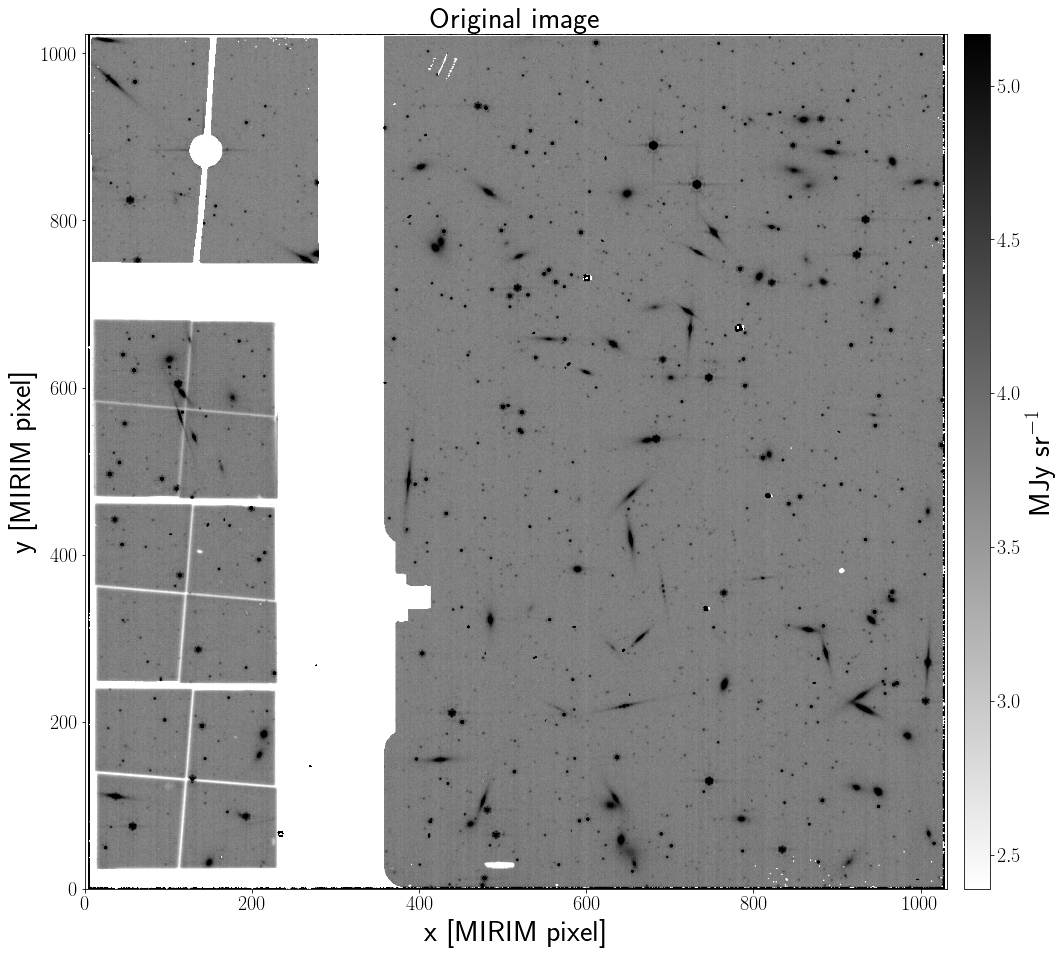

In [74]:
#plt.figure(figsize=(12, 12))
   
data_sb = im[1].data
#ax = plt.subplot(1, 1, 1)
#plt.xlabel("X [px]", fontdict=font2)
#plt.ylabel("Y [px]", fontdict=font2)
#plt.title(filt, fontdict=font2)

_, med, sig = sigma_clipped_stats(data_sb, sigma=5.0, maxiters=5)

# Inputs: 2D array, min value, max value, title, x-axis label, y-axis label, colorbar label, colormap
imshow_me_wcolorbar(data_sb, med-1*sig, med+1*sig, 'Original image', 'x [MIRIM pixel]', 'y [MIRIM pixel]', 'MJy sr$^{-1}$', 'binary')

#norm = simple_norm(data_sb, 'sqrt', percent=99.)
#ax.imshow(data_sb, norm=norm, cmap='Greys')
#plt.tight_layout()

Not all pixels should be used. We can use the Data Quality (DQ) flags to assess whether a pixel can be considered in calculations or not. [Here](https://jwst-pipeline.readthedocs.io/en/latest/jwst/references_general/references_general.html#data-quality-flags) you can find a description of the DQ flags.

There is no one-size-fits-all solution for selecting pixels using the DQ flags. For this specific exercise, let's keep all pixels with DQ flag equal to:

- 0 = Good pixel
- 2 = Pixel saturated during integration
- 4 = Jump detected during integration
- 6 = Combination of DQ flags 2 and 4

As we can see, the DQ flags can correspond to multiple features. We can use _dqflags.dqflags_to_mnemonics_ to convert the DQ integer values into more user-friendly names:

In [75]:
print(r' DQ flag equal to 2: {0}'.format(dqflags.dqflags_to_mnemonics(2, dqflags.group)))
print(r' DQ flag equal to 4: {0}'.format(dqflags.dqflags_to_mnemonics(4, dqflags.group)))
print(r' DQ flag equal to 6: {0}'.format(dqflags.dqflags_to_mnemonics(6, dqflags.group)))

 DQ flag equal to 2: {'SATURATED'}
 DQ flag equal to 4: {'JUMP_DET'}
 DQ flag equal to 6: {'JUMP_DET', 'SATURATED'}


In [76]:
ok = np.zeros(im[1].data.shape, dtype='int')
for v in [0, 2, 4, 6]:
    ok = ok + np.where(im[3].data == v, 1, 0)

im[1].data[ok == 0] = np.nan
print(r'{0} out of {1} pixels are not usable (~{2:3.1f}%)'.format((ok == 0).sum(), im[1].data.shape[0]*im[1].data.shape[1], 
                                                                  (ok == 0).sum()/(im[1].data.shape[0]*im[1].data.shape[1])*100.0))

311680 out of 1056768 pixels are not usable (~29.5%)


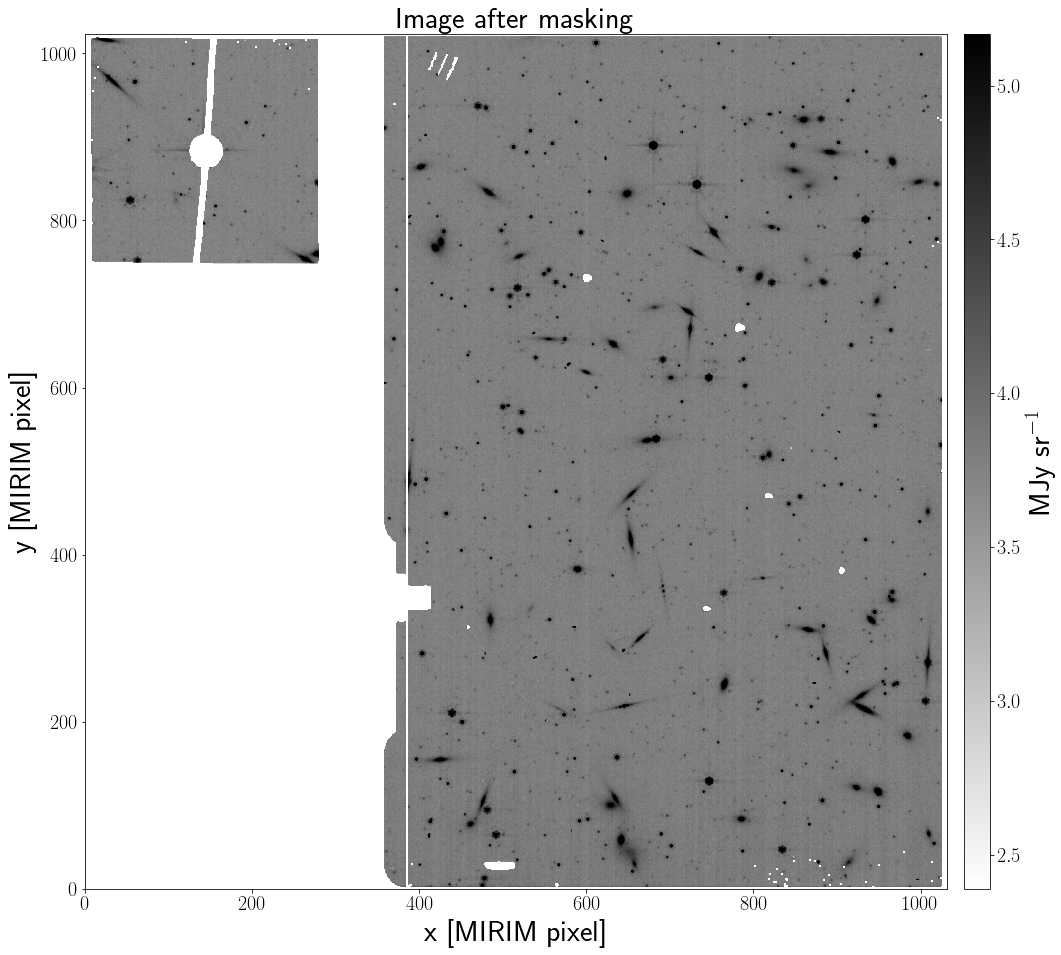

In [54]:
imshow_me_wcolorbar(im[1].data, med-1*sig, med+1*sig, 'Image after masking', 'x [MIRIM pixel]', 'y [MIRIM pixel]', 'MJy sr$^{-1}$', 'binary')

### 3.2<font color='white'>-</font>Convert image units and apply pixel area map<a class="anchor" id="convert_data"></a> ###

In [77]:
imh = im[1].header
data = data_sb / imh['PHOTMJSR']
print('Conversion factor from {units} to DN/s for filter {f}:'.format(units=imh['BUNIT'], f=filt), imh['PHOTMJSR'])
area = im[4].data
data = data * area

Conversion factor from MJy/sr to DN/s for filter F770W: 0.5927879810333252


In [78]:
#imshow_me_wcolorbar(im[1].data, med-1*sig, med+1*sig, 'Image after masking', 'x [MIRIM pixel]', 'y [MIRIM pixel]', 'MJy sr$^{-1}$', 'binary')
imviz = Imviz()
imviz.app

Application(config='imviz', events=['call_viewer_method', 'close_snackbar_message', 'data_item_selected', 'des…

**Note**: in this particular example, we analyze each image separately to provide a general overview of the different steps necessary to perform PSF photometry and to highlight the different functions adopted in this notebook.

In [79]:
imviz.load_data(data)
viewer = imviz.default_viewer
viewer.cuts = '95%'

4.<font color='white'>-</font>Analyze F770W Image <a class="anchor" id="analyze_image"></a>
------------------

### 4.1<font color='white'>-</font>Create a synthetic PSF with WebbPSF (single or grid)<a class="anchor" id="create_webbpsf"></a> ###

In [27]:
psfs_dir = 'PSF_MODELS/'

if not os.path.exists(psfs_dir):
    os.makedirs(psfs_dir)
    
# single:

psf_webbpsf_single_f770w = create_psf_model(det=det, filt=filt, fov=11, create_grid=False, save_psf=True, 
                                      detsampled=False)

# grid

psf_webbpsf_grid_f770w = create_psf_model(det=det, filt=filt, fov=11, create_grid=True, num=16, save_psf=True, 
                                    detsampled=False)

Using a 11 px fov

Creating a single PSF for filter F770W and detector MIRIM


Running instrument: MIRI, filter: F770W
  Running detector: MIRIM
    Position 1/1: (511, 511) pixels


2022-04-14 05:35:22,149 - stpipe - WARNING - /Users/ofox/miniconda3/envs/hackphot/lib/python3.8/site-packages/astropy/io/fits/card.py:1009: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',



  Saving file: PSF_MODELS/PSF_F770W_samp4_fov11_npsfs1_mirim.fits
Using a 11 px fov

Creating a grid of PSF for filter F770W and detector MIRIM


Running instrument: MIRI, filter: F770W
  Running detector: MIRIM
    Position 1/16: (0, 0) pixels


2022-04-14 05:35:34,607 - stpipe - WARNING - /Users/ofox/miniconda3/envs/hackphot/lib/python3.8/site-packages/webbpsf/opds.py:1739: UserWarning: For (V2,V3) = [-6.36393735 -7.26974788] arcmin, Field point -6.363937347326865 arcmin, -0.5632056 arcmin not within valid region for field dependence model of OTE WFE for MIRI: -8.254199999999999 arcmin--6.21738 arcmin, -2.557224 arcmin--0.5632056 arcmin. Clipping to closest available valid location, 0.03295348152304289 arcmin away from the requested coordinates.
  warnings.warn(f'For (V2,V3) = {v2v3}, Field point {x_field_pt}, {y_field_pt} not within valid region for field dependence model of OTE WFE for {instrument}: {min_x_field}-{max_x_field}, {min_y_field}-{max_y_field}. Clipping to closest available valid location, {clip_dist} away from the requested coordinates.')



    Position 2/16: (0, 341) pixels
    Position 3/16: (0, 682) pixels
    Position 4/16: (0, 1023) pixels
    Position 5/16: (341, 0) pixels
    Position 6/16: (341, 341) pixels
    Position 7/16: (341, 682) pixels
    Position 8/16: (341, 1023) pixels
    Position 9/16: (682, 0) pixels
    Position 10/16: (682, 341) pixels
    Position 11/16: (682, 682) pixels
    Position 12/16: (682, 1023) pixels
    Position 13/16: (1023, 0) pixels
    Position 14/16: (1023, 341) pixels
    Position 15/16: (1023, 682) pixels
    Position 16/16: (1023, 1023) pixels


2022-04-14 05:36:54,103 - stpipe - WARNING - /Users/ofox/miniconda3/envs/hackphot/lib/python3.8/site-packages/astropy/io/fits/card.py:1009: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',



  Saving file: PSF_MODELS/PSF_F770W_samp4_fov11_npsfs16_mirim.fits


Display the synthetic PSF (single)

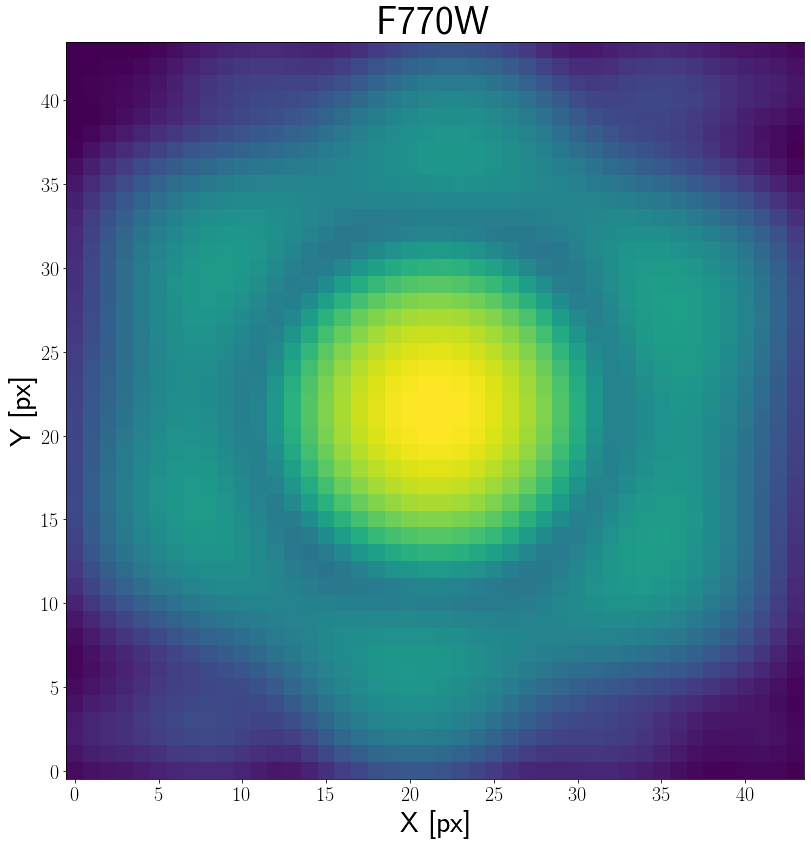

In [28]:
plt.figure(figsize=(12, 12))

ax = plt.subplot(1, 1, 1)

norm_psf = simple_norm(psf_webbpsf_single_f770w.data[0], 'log', percent=99.)
ax.set_title(filt, fontsize=40)
ax.imshow(psf_webbpsf_single_f770w.data[0], norm=norm_psf)
ax.set_xlabel('X [px]', fontsize=30)
ax.set_ylabel('Y [px]', fontsize=30)
plt.tight_layout()

Display the synthetic PSF (grid)

### 4.2<font color='white'>-</font>Perform PSF photometry <a class="anchor" id="psf_photometry"></a> ###

**Note**: remember to create a cutout of the original image

In [29]:
data1 = data

output_phot_dir = 'PHOT_OUTPUT/'

if not os.path.exists(output_phot_dir):
    os.makedirs(output_phot_dir)

res_dir = 'RESIDUAL_IMAGES/'

if not os.path.exists(res_dir):
    os.makedirs(res_dir)

if glob.glob(os.path.join(res_dir, 'residual*F770W.fits')):
    print('Deleting Residual images from directory')
    files = glob.glob(os.path.join(res_dir, 'residual*F770W.fits'))
    for file in files:
        os.remove(file)

psf_phot_results, residual_image = psf_phot(data=data1, det=det, filt=filt, th=5, psf=psf_webbpsf_grid_f770w, 
                                            save_residuals=True, save_output=True)

2022-04-14 05:36:54,402 - stpipe - WARNING - /Users/ofox/miniconda3/envs/hackphot/lib/python3.8/site-packages/astropy/stats/sigma_clipping.py:411: AstropyUserWarning: Input data contains invalid values (NaNs or infs), which were automatically clipped.
  warnings.warn('Input data contains invalid values (NaNs or '

2022-04-14 05:36:54,572 - stpipe - WARNING - /Users/ofox/miniconda3/envs/hackphot/lib/python3.8/site-packages/astropy/stats/sigma_clipping.py:411: AstropyUserWarning: Input data contains invalid values (NaNs or infs), which were automatically clipped.
  warnings.warn('Input data contains invalid values (NaNs or '



Deleting Residual images from directory
FWHM for filter F770W: 4.374


2022-04-14 05:36:54,791 - stpipe - WARNING - /Users/ofox/miniconda3/envs/hackphot/lib/python3.8/site-packages/astropy/stats/sigma_clipping.py:411: AstropyUserWarning: Input data contains invalid values (NaNs or infs), which were automatically clipped.
  warnings.warn('Input data contains invalid values (NaNs or '



Performing the PSF photometry --- Detector MIRIM, filter F770W


2022-04-14 05:36:58,793 - stpipe - WARNING - /Users/ofox/miniconda3/envs/hackphot/lib/python3.8/site-packages/astropy/modeling/fitting.py:1169: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-04-14 05:37:24,392 - stpipe - WARNING - /Users/ofox/miniconda3/envs/hackphot/lib/python3.8/site-packages/astropy/modeling/fitting.py:1169: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-04-14 05:37:27,272 - stpipe - WARNING - /Users/ofox/miniconda3/envs/hackphot/lib/python3.8/site-packages/astropy/modeling/fitting.py:1169: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "



Time needed to perform photometry: 0.01 hours
Number of sources detected: 849


Display the residual image

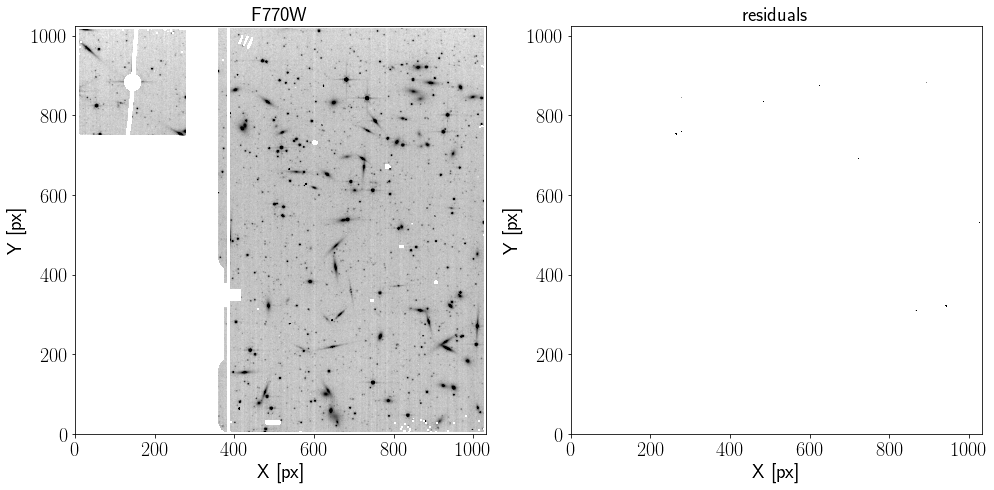

In [30]:
plt.figure(figsize=(14, 14))

ax1 = plt.subplot(2, 2, 1)

plt.xlabel("X [px]", fontdict=font2)
plt.ylabel("Y [px]", fontdict=font2)
plt.title(filt, fontdict=font2)

norm = simple_norm(data1, 'sqrt', percent=99.)
ax1.imshow(data1, norm=norm, cmap='Greys')

ax2 = plt.subplot(2, 2, 2)

plt.xlabel("X [px]", fontdict=font2)
plt.ylabel("Y [px]", fontdict=font2)
plt.title('residuals', fontdict=font2)

norm = simple_norm(data1, 'sqrt', percent=90., min_percent=40, max_percent=60)
ax2.imshow(residual_image, norm=norm, cmap='Greys')

#ax3 = plt.subplot(2, 2, 3)
#
#plt.xlabel("X [px]", fontdict=font2)
#plt.ylabel("Y [px]", fontdict=font2)
#plt.title(filt, fontdict=font2)
#
#norm = simple_norm(data, 'sqrt', percent=99.)
#ax3.imshow(data, norm=norm, cmap='Greys')
#
#ax4 = plt.subplot(2, 2, 4)
#
#if os.path.isfile('./residual_webbpsf_grid16_NRCB1_F115W.fits'):
#    res_f115w = './residual_webbpsf_grid16_NRCB1_F115W.fits'
#
#else:
#    print('Downloading F115W residual image')
#    
#    boxlink_res_f115w = 'https://stsci.box.com/shared/static/g4ffi7zowwlj91up4nkqxz38c1l4tpjx.fits'
#    boxfile_res_f115w = './residual_webbpsf_grid16_NRCB1_F115W.fits'
#    urllib.request.urlretrieve(boxlink_res_f115w, boxfile_res_f115w)
#    res_f115w = boxfile_res_f115w
#
#if os.path.isfile('./residual_webbpsf_grid16_NRCB1_F200W.fits'):
#    res_f200w = './residual_webbpsf_grid16_NRCB1_F200W.fits'
#
#else:
#    print('Downloading F200W residual image')
#    
#    boxlink_res_f200w = 'https://stsci.box.com/shared/static/mssn25cokiwfwco9f289nds7lennfgvv.fits'
#    boxfile_res_f200w = './residual_webbpsf_grid16_NRCB1_F200W.fits'
#    urllib.request.urlretrieve(boxlink_res_f200w, boxfile_res_f200w)
#    res_f200w = boxfile_res_f200w
#
#residual = res_f200w
#
#residual = fits.open(residual)
#res_data = residual[0].data
#
#plt.xlabel("X [px]", fontdict=font2)
#plt.ylabel("Y [px]", fontdict=font2)
#plt.title('residuals', fontdict=font2)
#
#ax4.imshow(res_data, norm=norm, cmap='Greys')

plt.tight_layout()

In [32]:
from jdaviz import Imviz
imviz = Imviz()
imviz.app

Application(config='imviz', events=['call_viewer_method', 'close_snackbar_message', 'data_item_selected', 'des…

In [33]:
imviz.load_data(residual_image,data_label='Residual')
imviz.load_data(data,data_label='Original')
viewer = imviz.default_viewer
viewer.cuts = '95%'

In [34]:
viewer_2_name='Window 2'
viewer_2 = imviz.create_image_viewer(viewer_name=viewer_2_name)

In [35]:
imviz.app.add_data_to_viewer(viewer_2_name, 'Residual')

In [36]:
viewer_2.cuts = '95%'

<hr style="border:1px solid gray"> </hr>

<img style="float: center;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>